# entrainement arbre de decision #

# imports #

In [8]:
import torch
import numpy as np
import os
import joblib

## import du dataset ##
on utilise encore des .pt alors que c'est pas necessaire pour rester général par rapport au mlp => on multiplie pas les datasets

In [16]:

root = "./dataset/"
inputs = []
targets = []
for dirpath, dirnames, filenames in os.walk(root):
    for filename in filenames:
        if filename.endswith(".pt"):

                path = root + "/" + filename
                print(path)
                data = torch.load(path,weights_only=False)
                input_array = data["input"]
                print(np.shape(input_array))
                input = input_array.reshape(-1)
                input = input.numpy()
                target = data["output"]
                target = target.numpy()
                inputs.append(input)
                targets.append(target)
X = np.stack(inputs)
y = np.stack(targets)
print(np.shape(X))
print(y)

./dataset//25_07_0705_00_00.pt
torch.Size([343])
./dataset//25_07_0705_15_00.pt
torch.Size([343])
./dataset//25_07_0705_30_00.pt
torch.Size([343])
./dataset//25_07_0705_45_00.pt
torch.Size([343])
./dataset//25_07_0706_00_00.pt
torch.Size([343])
./dataset//25_07_0706_15_00.pt
torch.Size([343])
./dataset//25_07_0706_30_00.pt
torch.Size([343])
./dataset//25_07_0707_15_00.pt
torch.Size([343])
./dataset//25_07_0707_30_00.pt
torch.Size([343])
./dataset//25_07_0707_45_00.pt
torch.Size([343])
./dataset//25_07_0708_00_00.pt
torch.Size([343])
./dataset//25_07_0708_15_00.pt
torch.Size([343])
./dataset//25_07_0708_30_00.pt
torch.Size([343])
./dataset//25_07_0708_45_00.pt
torch.Size([343])
./dataset//25_07_0709_00_00.pt
torch.Size([343])
./dataset//25_07_0709_15_00.pt
torch.Size([343])
./dataset//25_07_0709_30_00.pt
torch.Size([343])
./dataset//25_07_0709_45_00.pt
torch.Size([343])
./dataset//25_07_0710_00_00.pt
torch.Size([343])
./dataset//25_07_0710_15_00.pt
torch.Size([343])
./dataset//25_07_071

## séparation données train/test et entrainement de l'arbre multiclass (il y a un arbre par classe ##

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train_frac, y_test_frac = train_test_split(X, y, test_size=0.2)
print(X_train, X_test, y_train_frac, y_test_frac )

[[ 64.80002   67.600006  62.       ... 112.308    108.87     108.87    ]
 [ 62.600006  65.399994  59.80002  ... 110.016    113.454    110.016   ]
 [ 62.600006  66.20001   59.80002  ... 113.454    138.804    111.162   ]
 ...
 [ 63.399994  66.20001   61.200012 ... 108.87     112.308    107.724   ]
 [ 62.80002   65.399994  60.600006 ... 112.308    107.724    104.286   ]
 [ 62.80002   66.20001   60.600006 ... 112.308    108.87     110.016   ]] [[ 62.        64.80002   59.200012 ... 108.87     108.87     108.87    ]
 [ 63.399994  66.80002   61.200012 ... 105.432    113.454    105.432   ]
 [ 62.600006  65.399994  59.80002  ... 143.388    126.152    129.59    ]
 ...
 [ 62.        64.80002   59.200012 ... 107.724    112.308    108.87    ]
 [ 62.600006  65.399994  59.80002  ... 113.454    107.724    106.578   ]
 [ 64.80002   67.600006  62.       ... 104.286    112.308    108.87    ]] [[0.5012     0.7024     0.6982     0.5563     0.69446665]
 [0.50100005 0.7024     0.6982     0.5563     0.694466

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier
y_train = np.zeros(np.shape(y_train_frac))
y_test = np.zeros(np.shape(y_test_frac))
for i in range(len(y_train_frac)):
    for j in range(len(y_train_frac[i])):
        y_train[i][j] = round(y_train_frac[i][j])
for i in range(len(y_test_frac)):
    for j in range(len(y_test_frac[i])):
        y_test[i][j] = round(y_test_frac[i][j])

print(y_train.shape)
print(X_train.shape)
base_tree = DecisionTreeClassifier(max_depth=3)
clf = MultiOutputClassifier(base_tree)
clf.fit(X_train, y_train)


(1046, 5)
(1046, 343)


,estimator,DecisionTreeC...r(max_depth=3)
,n_jobs,None
,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None


## plot des arbres (utilisés dans le streamlit ##

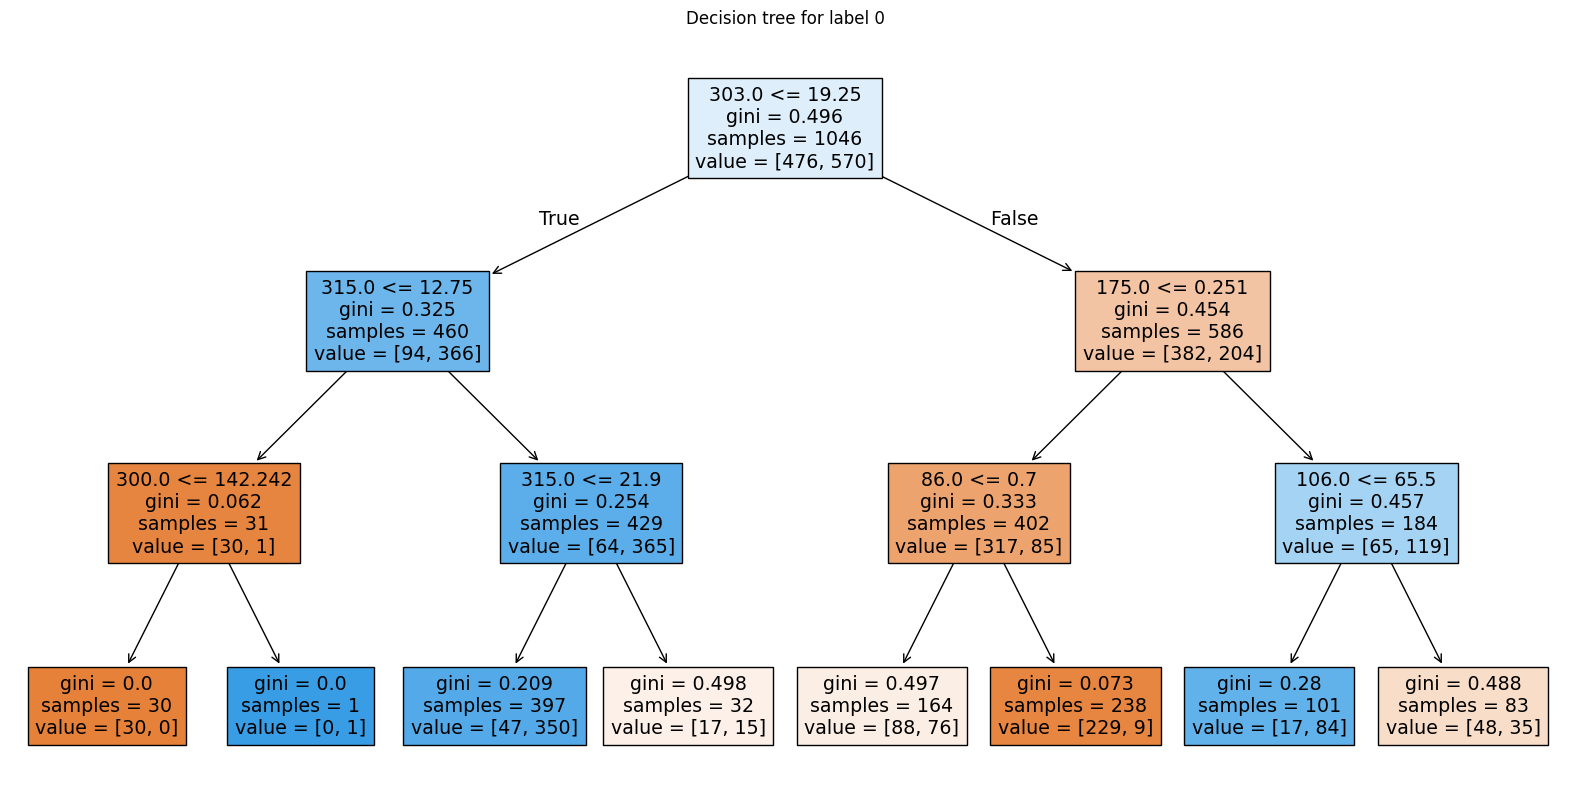

In [35]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
feature_names = np.linspace(0,342,343)
class_labels = ["pompe -4 mod","pompe +2 mod","pompe +27 mod","cogen mod","boilers mod"]
plot_tree(clf.estimators_[0], filled=True, feature_names=feature_names)
plt.title("Decision tree for label 0")
plt.show()

## predictions ##

In [36]:
def predict(X,clf):
    input = X
    input = input.reshape(1, -1)
    y_pred = clf.predict_proba(input)
    return y_pred
y = y_test[0]
y_pred = predict(X_test[0],clf)
print(f"y_pred {y_pred}")
print(f"y {y}")

probas = clf.predict_proba(X_test)

y_pred [array([[0.53658537, 0.46341463]]), array([[1.]]), array([[1.]]), array([[1.]]), array([[0.0338819, 0.9661181]])]
y [1. 1. 1. 1. 1.]


## calcul losses ##

In [37]:
from sklearn.metrics import f1_score, hamming_loss
binary_preds = []
for x in X_test:
    input = x.reshape(1, -1)
    pred = clf.predict(input)  # Liste de 11 tableaux (1D), un par classe
    binary_preds.append(pred[0])
binary_preds = np.array(binary_preds)
print("F1 score (micro):", f1_score(y_test, binary_preds, average='micro'))
print("Hamming loss:", hamming_loss(y_test, binary_preds))

F1 score (micro): 0.9688167449807774
Hamming loss: 0.055725190839694655


In [38]:
# Sauvegarde
joblib.dump(clf, "modele_multioutput.pkl")

['modele_multioutput.pkl']

## test d'utilisations ##

In [39]:
#test
test = torch.load('./dataset/25_07_2016_45_00.pt',weights_only=False)
X = test['input']
X = X.reshape(-1)
X = X.numpy()
print(np.shape(X))
clf_reloaded = joblib.load("modele_multioutput.pkl")
y_pred = predict(X,clf_reloaded)
print(f"y {test['output']}")
print(f"y_pred {y_pred}")

(343,)
y tensor([0.0000, 0.7024, 0.6982, 0.5563, 0.6945])
y_pred [array([[0.96218487, 0.03781513]]), array([[1.]]), array([[1.]]), array([[1.]]), array([[0.0338819, 0.9661181]])]


# test sortie de modulations


In [46]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import MultiOutputRegressor
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# y_train_frac : (n_samples, 12) dans [0,1]  (duty-cycle moyen ou 0/1)
reg = MultiOutputRegressor(
    DecisionTreeRegressor(max_depth=3, min_samples_leaf=20, random_state=0)
).fit(X_train, y_train_frac)

y_hat = reg.predict(X_test).clip(0, 1)         # proba/% par sortie
mae  = mean_absolute_error(y_test_frac, y_hat)
rmse = mean_squared_error(y_test_frac, y_hat)
print(f"mae {mae}")
print(f"rmse {rmse}")

joblib.dump(reg, "modele_multioutput_regression.pkl")

def prediction(reg):


mae 0.035908119816789055
rmse 0.010559214824142706


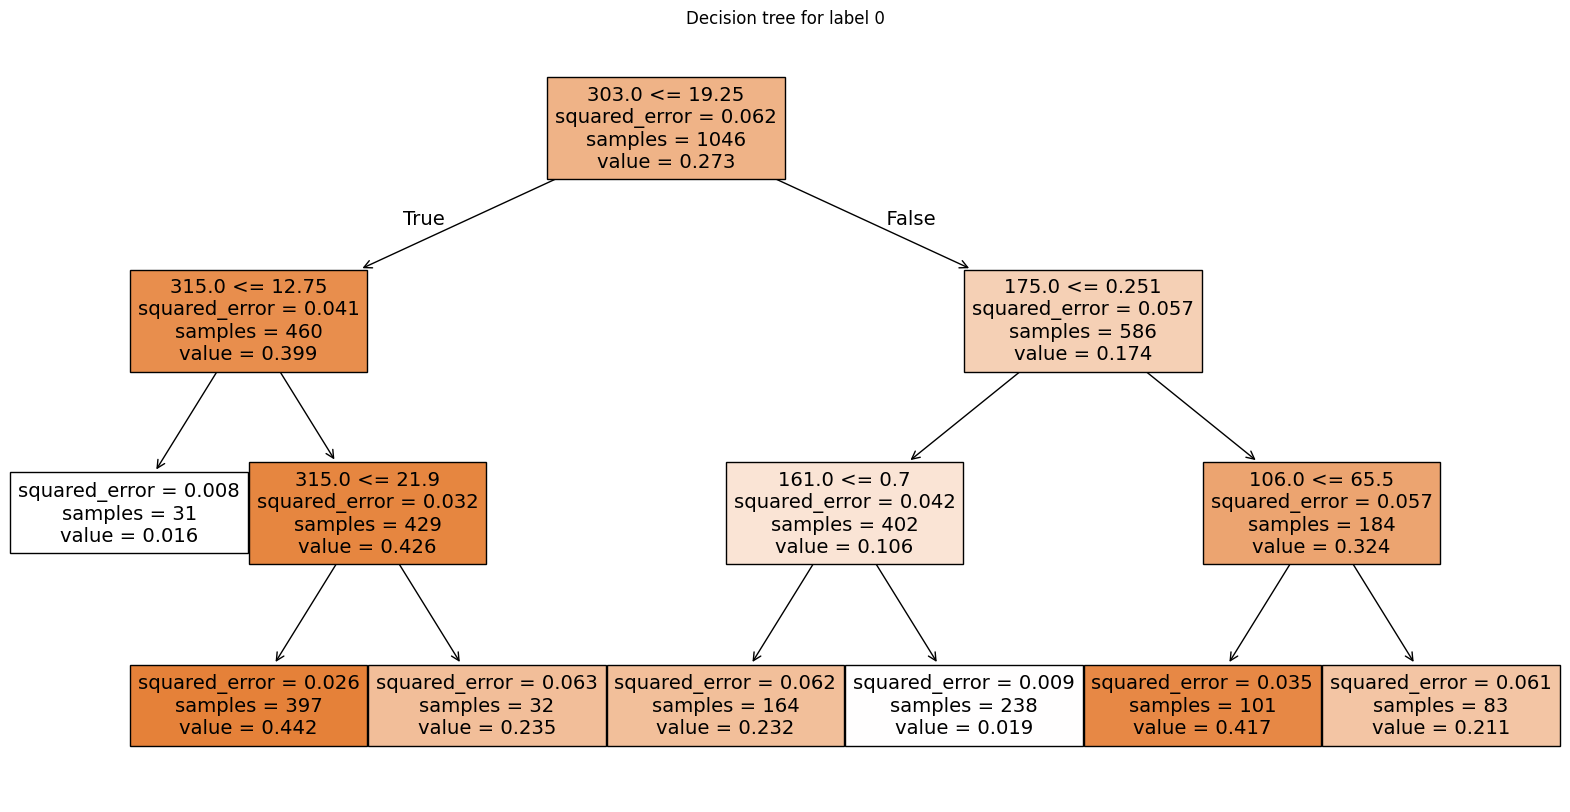

In [48]:
plt.figure(figsize=(20,10))
feature_names = np.linspace(0,342,343)
class_labels = ["pompe -4 mod","pompe +2 mod","pompe +27 mod","cogen mod","boilers mod"]
plot_tree(reg.estimators_[0], filled=True, feature_names=feature_names)
plt.title("Decision tree for label 0")
plt.show()